<a href="https://colab.research.google.com/github/drewwint/neuromatch-2021/blob/main/tutorials/W3D2_HiddenDynamics/student/W3D2_Tutorial3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 3: 1D Kalman Filter
**Week 3, Day 2: Hidden Dynamics**

**By Neuromatch Academy**

__Content creators:__ Itzel Olivos Castillo and Xaq Pitkow

__Content reviewers:__ Your names here


---
# Tutorial Objectives

In previous tutorials we used Hidden Markov Models (HMM) to infer *discrete* latent states from a sequence of measurements. In this tutorial, we will learn how to infer a *continuous* latent variable using the Kalman filter, which is one version of an HMM.

In this tutorial, you will:
* Review linear dynamical systems
* Learn about the Kalman filter in one dimension
* Manipulate parameters of process to see how the Kalman filter behaves
* Think about some core properties of the Kalman filter.

You can imagine this inference process happening as Mission Control tries to locate and track Astrocat. But you can also imagine that the brain is using an analogous Hidden Markov Model to track objects in the world, or to estimate the consequences of its own actions. And you could use this technique to estimate brain activity from noisy measurements, for understanding or for building a brain-machine interface.

# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import transforms
from collections import namedtuple
from scipy.stats import norm

gaussian = namedtuple('Gaussian', ['mean', 'cov'])

In [2]:
# @title Figure Settings
import ipywidgets as widgets       # interactive display
from ipywidgets import interactive, interact, HBox, Layout,VBox
from IPython.display import HTML
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [3]:
# @title Plotting Functions

def plot_trajectory(s, T):
  fig, ax = plt.subplots()
  ax.plot([0, T], [0, 0], 'k')
  ax.plot(s, color='limegreen', lw=2)
  ax.plot([T], [s[-1]], marker='o', markersize=8, color='limegreen')
  ax.set(xlabel = 'Time t', ylabel = 's(t)')

def plot_measurement(s, m, T):
  fig, axes = plt.subplots(1, 2)

  axes[0].plot(s, color='limegreen', lw=2, label='true position')
  axes[0].plot([T], [s[-1]], marker='o', markersize=8, color='limegreen')
  axes[0].plot(m, '.', color='crimson', lw=2, label='measurement')
  axes[0].set(xlabel = 'Time t', ylabel = 's(t)')

  sbounds = 1.1*max(max(np.abs(s)), max(np.abs(m)))
  axes[1].plot([-sbounds, sbounds], [-sbounds, sbounds], 'k')    # plot line of equality

  axes[1].scatter(s, m, marker='.', color='red', s=100)
  axes[1].set(xlabel = 'State', ylabel = 'Measurement')

def plot_function(u=1,v=2,w=3,x=4,y=5,z=6):
    time=np.arange(0,1,0.01)
    df=pd.DataFrame({"Y1":np.sin(time*u*2*np.pi),"y2":np.sin(time*v*2*np.pi),"y3":np.sin(time*w*2*np.pi),
                    "y4":np.sin(time*x*2*np.pi),"y5":np.sin(time*y*2*np.pi),"y6":np.sin(time*z*2*np.pi)})
    df.plot()

In [4]:
# @title Helper Functions

# Fixed params
T_max = 200
D = 1
tau_min = 1
tau_max = 50
process_noise_min = 0.1
process_noise_max = 10
measurement_noise_min = 0.1
measurement_noise_max = 10

unit_process_noise = np.random.randn(T_max)     # compute all N(0, 1) in advance to speed up time slider
unit_measurement_noise = np.random.randn(T_max)     # compute all N(0, 1) in advance to speed up time slider

def filter(D, process_noise, measurement_noise, belief, m, s):
    prior = gaussian(belief.mean, belief.cov)

    predicted_estimate = D * belief.mean
    predicted_covariance = D**2 * belief.cov + process_noise
    yesterdays_post = gaussian(predicted_estimate, predicted_covariance)

    likelihood = gaussian(m, measurement_noise)
    innovation_estimate = m - predicted_estimate
    innovation_covariance = predicted_covariance + measurement_noise

    K = predicted_covariance / innovation_covariance  # Kalman gain, i.e. the weight given to the difference between the measurement and predicted measurement
    updated_mean = predicted_estimate + K * innovation_estimate
    updated_cov = (1 - K) * predicted_covariance
    todays_posterior = gaussian(updated_mean, updated_cov)

    return prior, yesterdays_post, likelihood, todays_posterior

# Section 1: Astrocat Dynamics

In [5]:
# @title Video 1: Astrocat through time
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="P1jFKXDzAYQ", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

In [6]:
# @title Video 2: Introduction
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="hqYP3-M3rFg", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

## Section 1.1: Simulating Astrocat's movements

Astrocat's position $s_t$ is determined by the linear dynamical system $s_t = Ds_{t-1} + w_{t-1}$. $D$ is a scalar that models how astrocat would like to change its position over time and $w_t \sim \mathcal{N}(0, \sigma_p^2)$ is white Gaussian noise caused by unreliable actuators in astrocat's propulsion unit.

### Coding Exercise 1.1: Simulating Astrocat's movements

We will first simulate Astrocat's movements according to the linear dynamical system outlined above. 

You will complete a function `simulate_trajectory` below to simulate a possible trajectory,


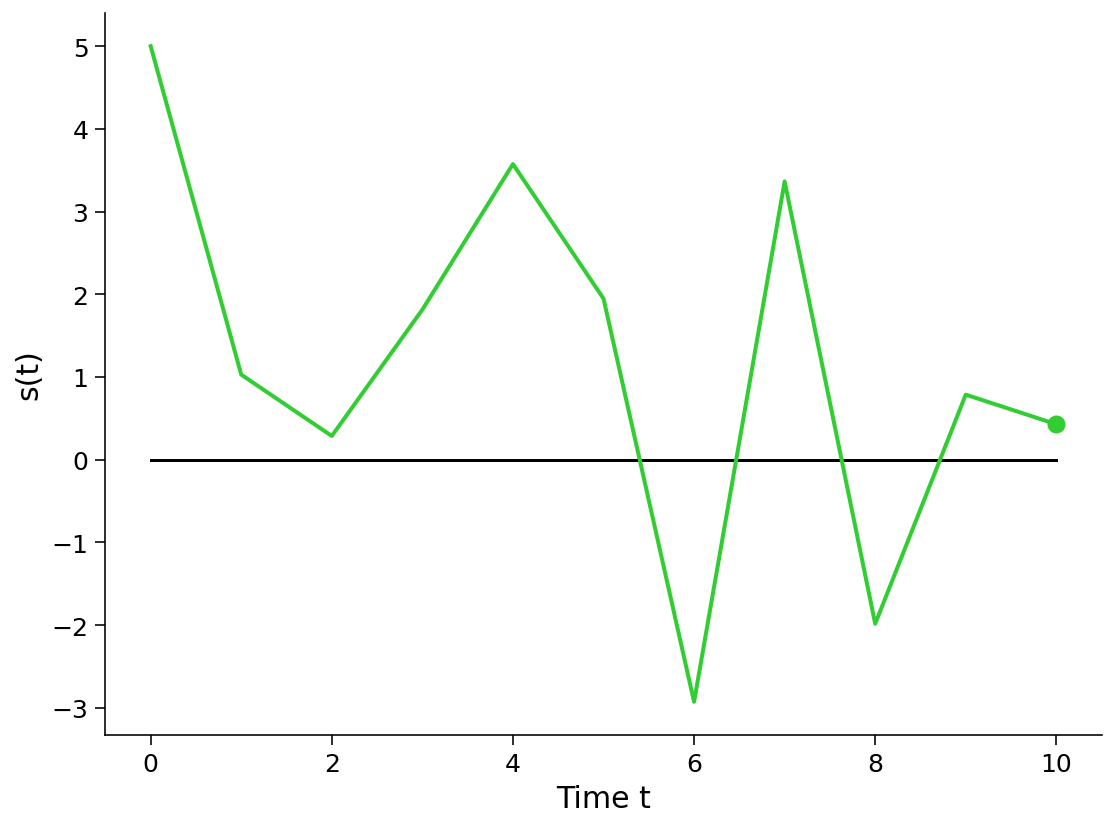

In [7]:
def simulate_trajectory(D, s0, sigma_eta, T):
  """ Compute the response of the linear dynamical system.

  Args:
    D (scalar): dynamics multiplier
    s0 (scalar): initial postion
    sigma_eta (scalar): amount of noise in the system
    T (scalar): total duration of the simulation

  Returns:
    ndarray: `s`: astrocat's trajectory up to time T
  """

  ###################################################################
  ## Fill out the following then remove
  ## raise NotImplementedError("Student exercise: need to implement simulation")
  ###################################################################

  # Initialize variables
  s = np.zeros(T + 1)
  s[0] = s0

  # Compute the position at time t given the position at time t-1 for all t
  # Consider that np.random.normal(mu, sigma) generates a random sample from
  # a gaussian with mean = mu and standard deviation = sigma

  for t in range(1, len(s)):

    s[t] = D*s[t-1] + np.random.normal(0, sigma_eta)

  return s

# Set random seed
np.random.seed(0)

# Choose parameters
D = -0.5    # parameter in f(x)
T = 10      # total Time duration
s0 = 5.     # initial condition of x at time 0
sigma_eta = 2 # amount of noise in the actuators of astrocat's propulsion unit

# Simulate trajectory
s = simulate_trajectory(D, s0, sigma_eta, T)

# Visualize
plot_trajectory(s, T)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D2_HiddenDynamics/solutions/W3D2_Tutorial3_Solution_e1815642.py)

*Example output:*

<img alt='Solution hint' align='left' width=558 height=413 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W3D2_HiddenDynamics/static/W3D2_Tutorial3_Solution_e1815642_0.png>



### Interactive Demo 1.1: Astrocat movement

In the demo below, you can play with the parameters, specially $D$ and the noise standard deviation $\sigma_p$, of the linear dynamical system governing Astrocat's movement. We will look at a longer time span.



1.   What happens when D is large (>1)? Why?
2.   What happens when D is a large negative number (<-1)? Why?
3.   What about when D is zero?




In [8]:
# @markdown Execute this cell to enable the widget

def simulate_trajectory(D, s0, sigma_eta, T):
  """ Compute the response of the linear dynamical system.

  Args:
    D (scalar): dynamics multiplier
    s0 (scalar): initial postion
    sigma_eta (scalar): amount of noise in the system
    T (scalar): total duration of the simulation

  Returns:
    ndarray: `s`: astrocat's trajectory up to time T
  """

  # Initialize variables
  s = np.zeros(T + 1)
  s[0] = s0

  # Compute the position at time t given the position at time t-1 for all t
  # Consider that np.random.normal(mu, sigma) generates a random sample from
  # a gaussian with mean = mu and standard deviation = sigma

  for t in range(1, len(s)):

    s[t] = D*s[t-1] + np.random.normal(0, sigma_eta)

  return s

@widgets.interact(D = widgets.FloatSlider(value=-.5, min=-2, max=2, step=0.1), sigma_p = widgets.FloatSlider(value=2.0, min=0, max=5, step=0.1))

def interactive_movement(D, sigma_p):

    # Choose parameters
    T = 100      # total Time duration
    s0 = 5.     # initial condition of x at time 0

    # Simulate trajectory
    s = simulate_trajectory(D, s0, sigma_p, T)

    # Visualize
    plot_trajectory(s, T)

interactive(children=(FloatSlider(value=-0.5, description='D', max=2.0, min=-2.0), FloatSlider(value=2.0, desc…

#### Answers
1) When D is large, the state at time step t will depend heavily on the state at time
   step t_1. If we forget about the noise term, D = 2 would mean that the state at each
   time step is double the one before! So the state becomes huge and basically explodes towards
   infinity.

2) If D is a large negative number, the state at time t will be a different sign than the
   state at time step t_1. So the state will oscillate over the x axis.

3) When D is zero, the state at time t will not depend on the previous state, it will just
   be drawn from the noise distribution
   _____________________________________________________________________________

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D2_HiddenDynamics/solutions/W3D2_Tutorial3_Solution_fd240254.py)



## Section 1.2: Measuring Astrocat's movements

### Coding Exercise 1.2: Reading measurements from Astrocat's collar

Since we will not have access to Astrocat's true position, we must estimate it using measurements of a noisy sensor attached to its collar. Complete the function below to read measurements from Astrocat's collar.

We show the measurement and state at every time step in the left plot. In the right plot, we make a scatter plot to compare measured state to true state.

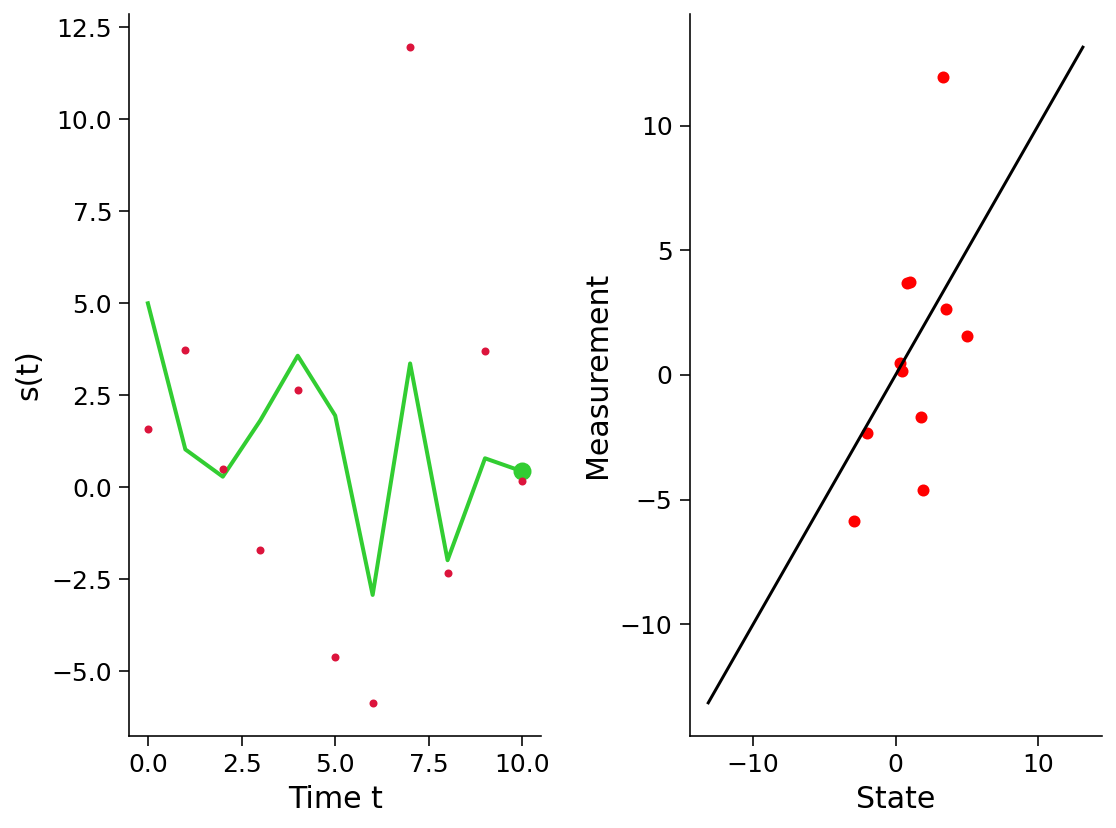

In [12]:
def read_collar(s, sigma_measurements):
  """ Compute the measurements of the noisy sensor attached to astrocat's collar

  Args:
    s (ndarray): astrocat's true position over time
    sigma_measurements (scalar): amount of noise in the sensor

  Returns:
    ndarray: `m`: astrocat's position over time according to the sensor
  """

  # Initialize variables
  m = np.zeros(len(s))

  # For all time t, add white Gaussian noise with magnitude sigma_measurements
  # Consider that np.random.normal(mu, sigma) generates a random sample from
  # a gaussian with mean = mu and standard deviation = sigma

  for t in range(len(s)):

    ###################################################################
    ## Fill out the following then remove
    ## raise NotImplementedError("Student exercise: need to implement read_collar function")
    ###################################################################

    m[t] = s[t] + sigma_measurements * np.random.randn()

  return m

# Choose parameters
sigma_measurement = 4 # amount of noise in astrocat's collar

# Read measurements from color
m = read_collar(s, sigma_measurement)

# Visualize
plot_measurement(s, m, T)

### Interactive Demo 1.2: Compare true states to measured states

In the following demo, you can change $\sigma_{measurement}$ and visualize the resulting measurements and measurement accuracy.

Before playing with the demo, discuss:


1.   What is the difference between $\sigma_{measurement}$ and the $\sigma_p$ we played with in Interactive Demo 1.1?
2. How will accuracy of measured state change with $\sigma_{measurement}$? 
3.   What will happen if $\sigma_{measurement}$ is 0?



In [10]:
# @markdown Execute this cell to enable the widget

@widgets.interact(sigma_m = widgets.FloatSlider(value=2.0, min=0, max=5, step=0.1))
def plot_measurement_quality(sigma_m):

  # Read measurements from color
  m = read_collar(s, sigma_m)

  # Visualize
  plot_measurement(s, m, T)

interactive(children=(FloatSlider(value=2.0, description='sigma_m', max=5.0), Output()), _dom_classes=('widget…

#### Answers
1) sigma_m is how much noise there is in the measurement observation model
   (the reading of the color location).
   sigma_p was the noise in the actual movement every step.

2) Accuracy will be worse with higher noise

3) If sigma_m is 0, the measured states will be fully accurate.
_________________________________________________________________________________________

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D2_HiddenDynamics/solutions/W3D2_Tutorial3_Solution_8bda671a.py)



As you can see by the measured state quality in the previous demo, using only the measurements to track astrocat can be catastrophic. A Kalman filter will solve this problem, as we will see in the next section!

---
# Section 2: The Kalman filter

In [13]:
# @title Video 3: Explanation of Kalman filter
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="EFCS55MtB-s", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

## Section 2.1: Using the Kalman filter

### Interactive Demo 2.1: The Kalman filter in action

Next we provide you with an interactive visualization to understand how the Kalman filter works. Play with the sliders to gain an intuition for how the different factors affect the Kalman filter's inferences.

The sliders:
* current time: Kalman filter synthesizes measurements up until this time.
* dynamics time constant $\tau$: this determines the dynamics matrix, $D=\exp{-\Delta t/\tau}$ where $\Delta t$ is the discrete time step (here 1).


In [14]:
#@markdown Execute this cell to enable the widget
display(HTML('''<style>.widget-label { min-width: 15ex !important; }</style>'''))

@widgets.interact(T=widgets.IntSlider(T_max/4, description="current time", min=2, max=T_max-1),
                  tau=widgets.FloatSlider(tau_max/2, description='dynamics time constant', min=tau_min, max=tau_max),
                  process_noise=widgets.FloatSlider(2, description="process noise", min=process_noise_min, max=process_noise_max),
                  measurement_noise=widgets.FloatSlider(3, description="observation noise", min=measurement_noise_min, max=measurement_noise_max),
                  flag_s = widgets.Checkbox(value=True, description='state', disabled=True, indent=False),
                  flag_m = widgets.Checkbox(value=False, description='measurement', disabled=False, indent=False),
                  flag_s_ = widgets.Checkbox(value=False, description='estimate', disabled=False, indent=False),
                  flag_err_ = widgets.Checkbox(value=False, description='estimator confidence intervals', disabled=False, indent=False))

def stochastic_system(T, tau, process_noise, measurement_noise, flag_m, flag_s_, flag_err_):
    t = np.arange(0, T_max, 1)              # timeline
    s = np.zeros(T_max)                     # states
    D = np.exp(-1/tau)                      # dynamics multiplier (matrix if s is vector)
    prior_mean = 0
    prior_cov = process_noise/(1-D**2)

    s[0] = np.sqrt(prior_cov) * unit_process_noise[0]   # Sample initial condition from equilibrium distribution

    m = np.zeros(T_max)    # measurement
    s_ = np.zeros(T_max)    # estimate (posterior mean)
    cov_ = np.zeros(T_max)    # uncertainty (posterior covariance)

    s_[0] = prior_mean
    cov_[0] = prior_cov
    posterior = gaussian(prior_mean, prior_cov)

    captured_prior = None
    captured_likelihood = None
    captured_posterior = None

    for i in range(1, T_max):
        s[i] = D * s[i-1] + np.sqrt(process_noise) * unit_process_noise[i-1]
        m[i] = s[i] + np.sqrt(measurement_noise) * unit_measurement_noise[i]

        prior, yesterdays_post, likelihood, posterior = filter(D, process_noise, measurement_noise, posterior, m[i], s[i])

        s_[i] =  posterior.mean
        cov_[i] = posterior.cov

        if i == T:
          captured_prior = prior
          captured_likelihood = likelihood
          captured_posterior = posterior

    smin = min(min(m),min(s-2*np.sqrt(cov_[-1])),min(s_-2*np.sqrt(cov_[-1])))
    smax = max(max(m),max(s+2*np.sqrt(cov_[-1])),max(s_+2*np.sqrt(cov_[-1])))
    pscale = 0.2  # scaling factor for displaying pdfs

    fig = plt.figure(figsize=[15, 10])
    ax = plt.subplot(2, 1, 1)
    ax.set_xlabel('time')
    ax.set_ylabel('state')
    ax.set_xlim([0, T_max+(T_max*pscale)])
    ax.set_ylim([smin, smax])

    show_pdf = [False, False]
    ax.plot(t[:T+1], s[:T+1], color='limegreen', lw=2)
    ax.plot(t[T:], s[T:], color='limegreen', lw=2, alpha=0.3)
    ax.plot([t[T:T+1]], [s[T:T+1]], marker='o', markersize=8, color='limegreen')

    if flag_m:
        ax.plot(t[:T+1], m[:T+1], '.', color='crimson', lw=2)
        ax.plot([t[T:T+1]], [m[T:T+1]], marker='o', markersize=8, color='crimson')

        domain = np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 500)
        pdf_likelihood = norm.pdf(domain, captured_likelihood.mean, np.sqrt(captured_likelihood.cov))
        ax.fill_betweenx(domain, T + pdf_likelihood*(T_max*pscale), T, color='crimson', alpha=0.5, label='likelihood', edgecolor="crimson", linewidth=0)
        ax.plot(T + pdf_likelihood*(T_max*pscale), domain, color='crimson', linewidth=2.0)

        ax.legend(ncol=3, loc='upper left')
        show_pdf[0] = True

    if flag_s_:
        ax.plot(t[:T+1], s_[:T+1], color='black', lw=2)
        ax.plot([t[T:T+1]], [s_[T:T+1]], marker='o', markersize=8, color='black')
        show_pdf[1] = True

    if flag_err_:
        ax.fill_between(t[:T+1], s_[:T+1] + 2 * np.sqrt(cov_)[:T+1], s_[:T+1] - 2 * np.sqrt(cov_)[:T+1], color='black', alpha=0.3)
        show_pdf[1] = True

    if show_pdf[1]:
        domain = np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 500)
        pdf_post = norm.pdf(domain, captured_posterior.mean, np.sqrt(captured_posterior.cov))
        ax.fill_betweenx(domain, T + pdf_post*(T_max*pscale), T, color='black', alpha=0.5, label='posterior', edgecolor="black", linewidth=0)
        ax.plot(T + pdf_post*(T_max*pscale), domain, color='black', linewidth=2.0)
        ax.legend(ncol=3, loc='upper left')

    if show_pdf[0] and show_pdf[1]:
        domain = np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 500)
        pdf_prior = norm.pdf(domain, captured_prior.mean, np.sqrt(captured_prior.cov))
        ax.fill_betweenx(domain, T + pdf_prior*(T_max*pscale), T, color='dodgerblue', alpha=0.5, label='prior', edgecolor="dodgerblue", linewidth=0)
        ax.plot(T + pdf_prior*(T_max*pscale), domain, color='dodgerblue', linewidth=2.0)
        ax.legend(ncol=3, loc='upper left')

plt.show()

interactive(children=(IntSlider(value=50, description='current time', max=199, min=2), FloatSlider(value=25.0,…

## Section 2.2: Estimation Accuracy

### Interactive Demo 2.2: Compare states, estimates, and measurements

How well do the estimates $\hat{s}$ match the actual values $s$? How does the distribution of errors $\hat{s}_t - s_t$ compare to the posterior variance? Why? Try different parameters of the Hidden Markov Model and observe how the properties change.

How do the _measurements_ $m$ compare to the true states?

In [15]:
#@markdown Execute this cell to enable the widget
display(HTML('''<style>.widget-label { min-width: 15ex !important; }</style>'''))

@widgets.interact(tau=widgets.FloatSlider(tau_max/2, description='tau', min=tau_min, max=tau_max),
                  process_noise=widgets.FloatSlider(2, description="process noise", min=process_noise_min, max=process_noise_max),
                  measurement_noise=widgets.FloatSlider(3, description="observation noise", min=measurement_noise_min, max=measurement_noise_max),
                  flag_m = widgets.Checkbox(value=False, description='measurements', disabled=False, indent=False))

def stochastic_system(tau, process_noise, measurement_noise, flag_m):
    T = T_max
    t = np.arange(0, T_max, 1)              # timeline
    s = np.zeros(T_max)                     # states
    D = np.exp(-1/tau)                      # dynamics multiplier (matrix if s is vector)
    prior_mean = 0
    prior_cov = process_noise/(1-D**2)

    s[0] = np.sqrt(prior_cov) * np.random.randn()   # Sample initial condition from equilibrium distribution

    m = np.zeros(T_max)    # measurement
    s_ = np.zeros(T_max)    # estimate (posterior mean)
    cov_ = np.zeros(T_max)    # uncertainty (posterior covariance)

    s_[0] = prior_mean
    cov_[0] = prior_cov
    posterior = gaussian(prior_mean, prior_cov)

    for i in range(1, T):
        s[i] = D * s[i-1] + np.sqrt(process_noise) * np.random.randn()
        m[i] = s[i] + np.sqrt(measurement_noise) * np.random.randn()

        prior, yesterdays_post, likelihood, posterior = filter(D, process_noise, measurement_noise, posterior, m[i], s[i])

        s_[i] =  posterior.mean
        cov_[i] = posterior.cov

    fig = plt.figure(figsize=[10, 5])
    ax = plt.subplot(1, 2, 1)
    ax.set_xlabel('s')
    ax.set_ylabel('$\mu$')

    sbounds = 1.1*max(max(np.abs(s)), max(np.abs(s_)), max(np.abs(m)))
    ax.plot([-sbounds, sbounds], [-sbounds, sbounds], 'k')    # plot line of equality
    ax.errorbar(s, s_, yerr=2*np.sqrt(cov_[-1]), marker='.', mfc='black', mec='black', linestyle='none', color='gray')

    axhist = plt.subplot(1, 2, 2)
    axhist.set_xlabel('error $s-\hat{s}$')
    axhist.set_ylabel('probability')
    axhist.hist(s-s_, density=True, bins=25, alpha=.5, label='histogram of estimate errors', color='yellow')

    if flag_m:
        ax.plot(s, m, marker='.', linestyle='none', color='red')
        axhist.hist(s-m,density=True,bins=25,alpha=.5,label='histogram of measurement errors',color='orange')

    domain = np.arange(-sbounds, sbounds, 0.1)
    pdf_g = norm.pdf(domain, 0, np.sqrt(cov_[-1]))
    axhist.fill_between(domain, pdf_g, color='black', alpha=0.5, label=r'posterior shifted to mean')
    axhist.legend()

plt.show()

interactive(children=(FloatSlider(value=25.0, description='tau', max=50.0, min=1.0), FloatSlider(value=2.0, de…

## Section 2.3: How long does it take to find astrocat?

### Interactive Demo 2.3: Search duration

Here we plot the posterior variance as a function of time. Before mission control gets measurements, their only information about astrocat's location is the prior. After some measurements, they home in on astrocat.
* How does the variance shrink with time?
* The speed depends on the process dynamics, but does it also depend on the signal-to-noise ratio (SNR)? (Here we measure SNR in decibels, a log scale where 1 dB means 0.1 log unit.)

The red curve shows how rapidly the latent variance equilibrates from an initial condition. (It's exponential with a time constant of $\sim 1/(1-D^2)$.) Does the latent process converge faster or slower than the posterior converges? Can you explain this based on how the Kalman filter integrates evidence?


In [16]:
#@title Initial transient for finding Astrocat
display(HTML('''<style>.widget-label { min-width: 15ex !important; }</style>'''))

@widgets.interact(T=widgets.IntSlider(tau_max/2, description="max time", min=2, max=T_max-1),
                  tau=widgets.FloatSlider(tau_max/2, description='time constant', min=tau_min, max=tau_max),
                  SNRdB=widgets.FloatSlider(-20., description="SNR (decibels)", min=-40., max=10.))

def stochastic_system(T, tau, SNRdB):
    t = np.arange(0, T, 1)              # timeline
    s = np.zeros(T)                     # states
    D = np.exp(-1/tau)                  # dynamics matrix (scalar here)
    prior_mean = 0
    process_noise = 1
    SNR = 10**(.1*SNRdB)
    measurement_noise = process_noise / SNR
    prior_cov = process_noise/(1-D**2)

    s[0] = np.sqrt(prior_cov) * unit_process_noise[0]   # Sample initial condition from equilibrium distribution

    m = np.zeros(T)    # measurements
    s_ = np.zeros(T)    # estimates (posterior mean)
    cov_ = np.zeros(T)    # uncertainty (posterior covariance)

    s_[0] = prior_mean
    cov_[0] = prior_cov
    posterior = gaussian(prior_mean, prior_cov)

    for i in range(1, T):
        s[i] = D * s[i-1] + np.sqrt(process_noise) * unit_process_noise[i-1]
        m[i] = s[i] + np.sqrt(measurement_noise) * unit_measurement_noise[i]

        prior, yesterdays_post, likelihood, posterior = filter(D, process_noise, measurement_noise, posterior, m[i], s[i])

        s_[i] =  posterior.mean
        cov_[i] = posterior.cov

    equilibrium_var = process_noise * (D**2 - 1 - SNR + np.sqrt((D**2 - 1 - SNR)**2 + 4 * D**2 * SNR)) / (2 * D**2 * SNR)

    fig = plt.figure()
    plt.xlabel('time')
    plt.ylabel('variance')
    plt.xlim([0, T])
    plt.ylim([0, max(cov_)])

    plt.fill_between(t, 0, cov_, color='black', alpha=0.3)
    plt.plot(t, cov_, color='black', label='posterior variance')
    plt.plot(t, equilibrium_var + (prior_cov - equilibrium_var) * np.exp(-2*t/tau), color='red', label='autocorrelation of hidden process')
    plt.legend()

plt.show()

interactive(children=(IntSlider(value=25, description='max time', max=199, min=2), FloatSlider(value=25.0, des…

---
# Section 3: Applications of Kalman filter in brain science

* Brain-Computer Interface: estimate intended movements using neural activity as measurements.
* Data analysis: estimate brain activity from noisy measurements (e.g. EEG)
* Model of perception: prey tracking using noisy sensory measurements
* Imagine your own! When are you trying to estimate something you cannot see directly?

There are many variants that improve upon the limitations of the Kalman filter: non-Gaussian states and measurements, nonlinear dynamics, and more.

---
# Summary


**Useful references:**
- Roweis, Ghahramani (1998): A unifying review of linear Gaussian Models
- Bishop (2006): Pattern Recognition and Machine Learning